# UMAP projections of over-expression morphological profiles for selected genes 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
import umap

import cpmolgan.utils as utils
import cpmolgan.visualization as vi
import pkg_resources
WEIGHTS_PATH = pkg_resources.resource_filename('cpmolgan','model_weights')


In [2]:
args = {
    'filename_train_profiles':'../../data/train_set_30kcpds_normalized_profiles.csv.gz',
    'filename_oe_profiles':'../../data/test_set_overexpression_normalized_profiles.csv',
    'top_10_diff_genes' :['DMSO', 'RAF1', 'JUN', 'ATF4', 'BRAF', 'CEBPA', 'RELB', 'MEK1', 'PIK3CD','AKT3', 'WWTR1'],
    'Excape_genes':["TP53","BRCA1","NFKB1","HSPA5", "CREBBP", "STAT1", "STAT3","HIF1A", "NFKBIA","JUN","PRKAA1","PDPK1"],
    'figures_dir':'figures'
}

if not os.path.isdir(args["figures_dir"]):
    os.makedirs(args["figures_dir"])

## 1. Read profiles

In [3]:
# Overexpression dataset (test)
data_oe = pd.read_csv(args['filename_oe_profiles'], index_col=0 )
data_oe = data_oe.drop(columns=['ORF Sequence', 'Quality Control','Median Replicate Correlation','Morphological Cluster ID'])
data_oe.loc[ data_oe['Control Type'] =='negative control',"Gene_Symbol"] = "DMSO"
feature_cols , _ = utils.get_feature_cols(data_oe)

# DMSO controls from the training set
train = pd.read_csv(args['filename_train_profiles'],index_col=0)
train_dmso = train.query('Metadata_broad_sample=="DMSO"').reset_index(drop=True)

## 2. Apply quantile transformer

In [4]:
quantile_transformer =  pickle.load( open( os.path.join(WEIGHTS_PATH,'quantile_transformer.pkl'), 'rb' ) )
data_oe[feature_cols] = quantile_transformer.transform(data_oe[feature_cols].values)   
train_dmso[feature_cols] = quantile_transformer.transform(train_dmso[feature_cols].values)   


## 3. Prepare data subset to find the projections
All genes plus a random sample of DMSO profiles in OE and train set

In [5]:
selected_genes = ["TP53","BRCA1","HSPA5","NFKB1", "CREBBP", "STAT1", "STAT3","HIF1A", "NFKBIA"]
plot_oe = data_oe.loc[ data_oe.Gene_Symbol.isin(selected_genes) ]

# get random DMSO smaples from OE and train set
dmso_subset = data_oe.loc[ data_oe.Gene_Symbol=="DMSO" ].sample(25,random_state=10)
dmso_subset["Gene_Symbol"]='DMSO'
dmso_subset_train = train_dmso.sample(25,random_state =10)
dmso_subset_train['Gene_Symbol']= 'DMSO_train'

# merge everything
plot_oe = pd.concat( [ plot_oe, dmso_subset, dmso_subset_train ]).reset_index(drop=True)
features = plot_oe[feature_cols].values.astype(float)

## 4. Compute UMAP projections

In [6]:
reducer = umap.UMAP(random_state=10)
oe_emb_umap = reducer.fit_transform(features)

## 5. Plot results (Figure 3)

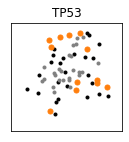

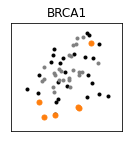

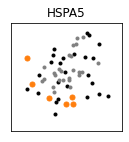

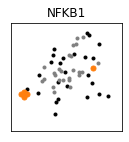

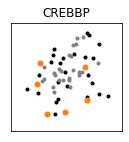

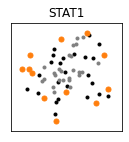

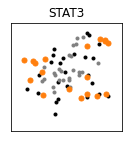

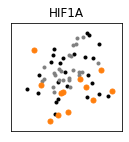

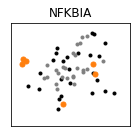

In [7]:
color = [1. , 0.49803922, 0.05490196, 1]
for i, gene in enumerate( selected_genes):
    umap_fig = plt.figure(figsize=(2,2))
    idx_gene , idx_dmso, idx_dmso_train = plot_oe.Gene_Symbol==gene, plot_oe.Gene_Symbol=='DMSO', plot_oe.Gene_Symbol=='DMSO_train'
    plt.plot( oe_emb_umap[idx_dmso,0], oe_emb_umap[idx_dmso,1], 'o', color=vi.gene_colors_dict['DMSO'], markersize=3)
    plt.plot(  oe_emb_umap[idx_dmso_train,0], oe_emb_umap[idx_dmso_train,1], 'o', color=vi.gene_colors_dict['DMSO_train'], markersize=3)
    plt.plot( oe_emb_umap[idx_gene,0], oe_emb_umap[idx_gene,1], 'o', color=color,markersize=5)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([oe_emb_umap[:,0].min()-0.5,oe_emb_umap[:,0].max()+0.5])
    plt.ylim([oe_emb_umap[:,1].min()-0.5,oe_emb_umap[:,1].max()+0.5])
    plt.title(gene)
    umap_fig.savefig(os.path.join( args['figures_dir'],'Umap_OE_profiles_'+gene+'.pdf'))
plt.tight_layout()


## Supplementary Figure 3

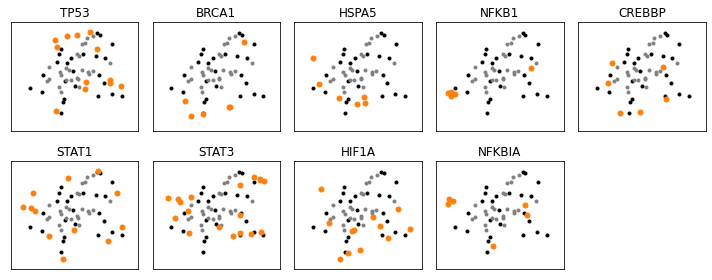

In [8]:
umap_fig = plt.figure(figsize=(10,4))
for i, gene in enumerate( selected_genes):
    plt.subplot(2,5,i+1)
    idx_gene , idx_dmso, idx_dmso_train = plot_oe.Gene_Symbol==gene, plot_oe.Gene_Symbol=='DMSO', plot_oe.Gene_Symbol=='DMSO_train'
    plt.plot( oe_emb_umap[idx_dmso,0], oe_emb_umap[idx_dmso,1], 'o', color=vi.gene_colors_dict['DMSO'], markersize=3)
    plt.plot(  oe_emb_umap[idx_dmso_train,0], oe_emb_umap[idx_dmso_train,1], 'o', color=vi.gene_colors_dict['DMSO_train'], markersize=3)
    plt.plot( oe_emb_umap[idx_gene,0], oe_emb_umap[idx_gene,1], 'o', color=color,markersize=5)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([oe_emb_umap[:,0].min()-0.5,oe_emb_umap[:,0].max()+0.5])
    plt.ylim([oe_emb_umap[:,1].min()-0.5,oe_emb_umap[:,1].max()+0.5])
    plt.title(gene)
plt.tight_layout()
umap_fig.savefig(os.path.join(args['figures_dir'],'Umap_OE_profiles_Excape_genes.pdf'))